In [263]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline


In [265]:
# import mc data file
# mcfile = 'mc_data/mc_data_trial5.npy'
mcfile = 'mc_data/testing.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 'dsa', 'unxsec'])


In [267]:
mc_df

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,dsa,unxsec
0,14400.0,6.770144,0.004036,0.457034,3.906001,0.379971,0.788619,6.143458,3.166685,385291.024326,2.042379e+06
1,14400.0,8.998006,0.009421,0.887314,3.757782,0.700260,0.596803,2.936050,1.992748,142017.655860,4.610291e+05
2,14400.0,9.107117,0.008611,0.872102,8.981659,0.606598,0.668911,1.051199,4.797260,637.812977,3.563325e+03
3,14400.0,8.585793,0.006448,0.974874,5.492025,0.680780,0.793924,2.194085,5.737386,25494.681852,7.806846e+04
4,14400.0,6.200460,0.008529,0.422734,6.993069,0.382973,0.313024,4.905882,4.621832,6158.341037,3.620580e+04
...,...,...,...,...,...,...,...,...,...,...,...
995,14400.0,8.836094,0.006321,0.551452,5.326435,0.300799,0.857742,4.099540,3.486669,30217.270933,9.036456e+04
996,14400.0,9.431611,0.008779,0.474699,7.255774,0.760712,0.703626,1.623079,6.038072,3392.930254,7.820011e+03
997,14400.0,6.160402,0.003172,0.308455,5.994914,0.596253,0.830879,3.549396,5.150287,28184.680862,2.877720e+05
998,14400.0,8.989203,0.007421,0.655395,9.284445,0.317592,0.756128,4.715512,2.838879,445.778760,2.478740e+03


In [339]:
# function to plot histograms

def plot_histogram(df, plot_q, weight, constraints={}, vary_q=None, **options):

    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [5, 1]})

    # make bins
    range = [df[plot_q].min(), df[plot_q].max()]
    nbins = options.get('nbins', 10)
    bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
    bins = np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width)
    # print(bins)

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
    fixed_df = df[mask]

    if fixed_df.empty:
        print('Error: selected df is empty - constraints are too constraining')
        return

    assert weight in ['dsa', 'total', 'both', 'ratio'], f'Error: option for weight {weight} not recognized'
    lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1

    colors = ['blue', 'red']

    # make plot data
    if vary_q:
        var, values = list(vary_q.items())[0]
        for value in values:
            vfixed_df = fixed_df[fixed_df[var].between(value*0.99, value*1.01)] # default here is requested value is within 1%

            dsa_counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins, weights=vfixed_df['dsa'])
            un_counts, _ = np.histogram(vfixed_df[plot_q], bins=bins, weights=vfixed_df['unxsec'])
            n_entries, _ = np.histogram(vfixed_df[plot_q], bins=bins)

            dsa_counts /= bin_width*n_entries
            un_counts /= bin_width*n_entries
            
            errors = np.sqrt(un_counts)/lumi
                   
            bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
            bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])

            if weight == 'dsa': plot_counts = [dsa_counts]
            elif weight == 'total': plot_counts = [un_counts]
            elif weight == 'both': plot_counts = [dsa_counts, un_counts]
            elif weight == 'ratio': 
                plot_counts = [dsa_counts/un_counts]
                errors = np.sqrt((1+plot_counts[0])/(lumi*un_counts))

            for i, ic in enumerate(plot_counts):
                label = options.get('label', fr'${var} = {value}\pm{value*0.01}$')
                if weight == 'both': label += f' ({['DSA', 'Total'][i]})'
                            
                ax.errorbar(
                    bin_centers, ic, yerr=errors,
                    fmt=options.get('fmt', 'o'),
                    capsize=3, elinewidth=1, capthick=1, color=colors[i]
                )
                ax.step(plot_bins, np.append(ic, ic[-1]), where='post', linestyle='-', color=colors[i], label=label)      
            
        ax.legend()
            
    else: 
        dsa_counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['dsa'])
        un_counts, _ = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['unxsec'])
        n_entries, _ = np.histogram(fixed_df[plot_q], bins=bins)

        # ensure bins are properly averaged
        dsa_counts /= bin_width*n_entries
        un_counts /= bin_width*n_entries
        
        errors = np.sqrt(un_counts/lumi)
               
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
        bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
    
        if weight == 'dsa': plot_counts = [dsa_counts]
        elif weight == 'total': plot_counts = [un_counts]
        elif weight == 'both': plot_counts = [dsa_counts, un_counts]
        elif weight == 'ratio': 
            plot_counts = [dsa_counts/un_counts]
            errors = np.sqrt((1+plot_counts[0])/(lumi*un_counts))
    
        for i, ic in enumerate(plot_counts):
            label = options.get('label', fr'')
            if weight == 'both': label += f' ({['DSA', 'Total'][i]})'
            ax.errorbar(
                bin_centers, ic, yerr=errors,
                fmt=options.get('fmt', 'o'), 
                capsize=3, elinewidth=1, capthick=1, color=colors[i]
            )
            ax.step(plot_bins, np.append(ic, ic[-1]), where='post', linestyle='-', color=colors[i], label=label)  

        if weight == 'both': ax.legend()

    # make info box for constraints
    info_text = 'Constraints:\n'
    for var, (low, high) in constraints.items():
        info_text += fr'${var}: [{low}, {high}]$'+'\n'
    ax_info.text(
        -0.3, 0.75, info_text, 
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.3)
    )
    ax_info.set_axis_off()

    # set plot info
    if options.get('y_limits'): ax.set_ylim(options.get('y_limits'))
    if options.get('x_limits'): ax.set_xlim(options.get('x_limits'))
    ax.set_title(options.get('title', ''))
    ax.set_ylabel(options.get('y_label', 'Frequency'))
    ax.set_xlabel(options.get('x_label', fr'${plot_q}$'))
    ax.set_yscale(options.get('y_scale', 'linear'))
    ax.set_xscale(options.get('x_scale', 'linear'))
    ax.grid(options.get('grid', True)) 



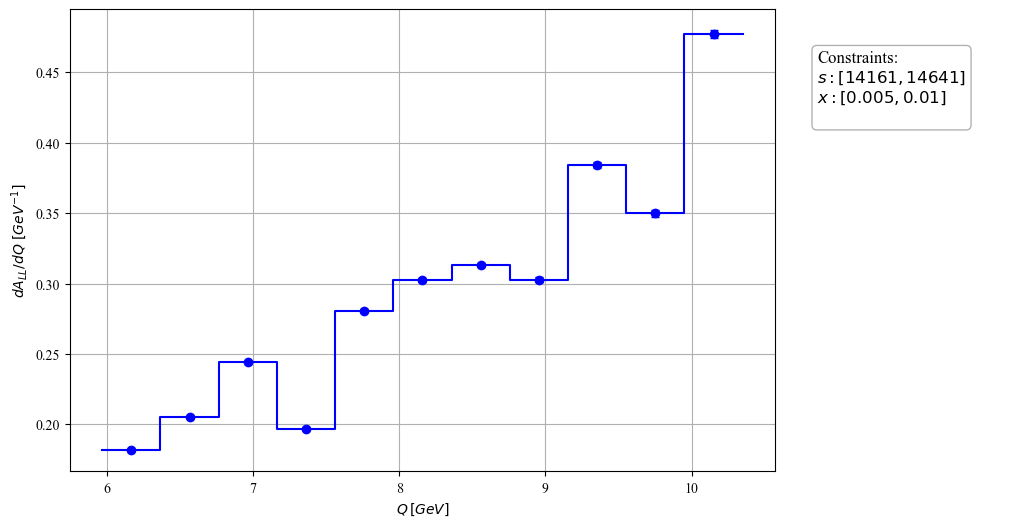

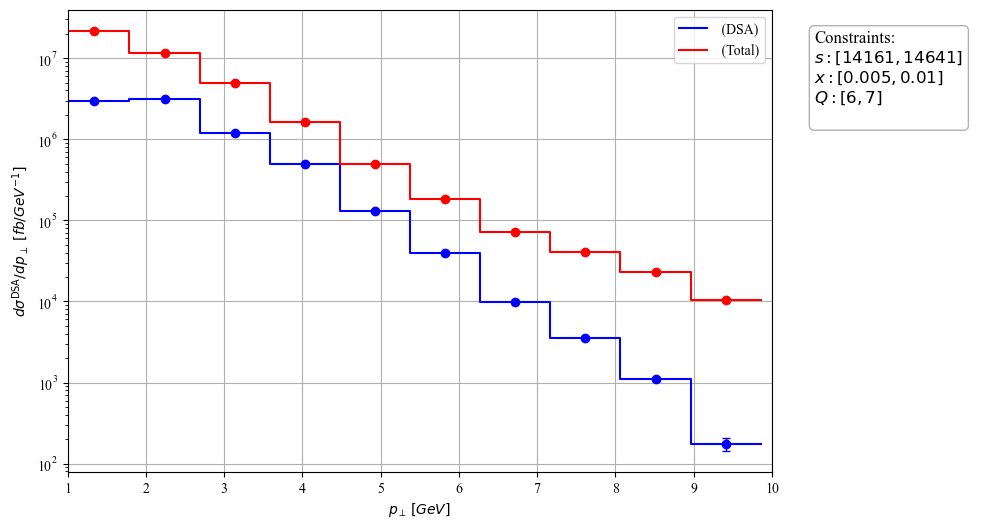

In [347]:
plot_s = 120
delta_s = 1

plot_histogram(mc_df, 'Q', 'ratio', 
                   {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2],
                    'x': [0.005, 0.01],
                    # 'Q': [6, 7]
                   }, 
                   lumi = 1,
                   y_scale='linear', 
                   # x_scale='log',
                   # x_limits = [5, 10], 
                   # y_limits = [0,0.35],
                   y_label=r'$dA_{LL}/dQ\,\,[GeV^{-1}]$', x_label=r'$Q\, [GeV]$')


plot_histogram(mc_df, 'pT', 'both', 
                   {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2],
                    'x': [0.005, 0.01],
                    'Q': [6, 7],
                   }, 
                   y_scale = 'log',
                   nbins = 10,
                   lumi = 10, x_limits = [1, 10],
                   y_label=r'$d\sigma^{\mathrm{DSA}}/dp_{\perp}\,\,[fb/GeV^{-1}]$', x_label=r'$p_\perp\, [GeV]$')

# plot_histogram(mc_df, 'Q', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2], 'y':[0.1, 0.9]}, vary_q={'z': [0.2, 0.3, 0.4, 0.5]})

# plot_histogram(mc_df, 'z', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, vary_q={'Q': [6, 7, 8, 9]}, weight='dsa')

# plot_histogram(mc_df, 'phi_kp', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, nbins=10)

